## Comic Book Covers
### Image & Metadata Analysis

This notebook contains an exploratory data analysis of comic book images and metadata scraped from https://comics.org. The custom methods created for this analysis come w/ tests and docstrings and can be found in the `comics_net.webscraper` and `comics_net.analyzer` modules.

In [1]:
import re
import os
import numpy as np
import pandas as pd
from PIL import Image

from comics_net import analyzer
from comics_net.webscraper import strip_brackets

In [2]:
# load the metadata
df = analyzer.load_metadata('../metadata/covers.jsonl')

# parse issue number and cast as int
df['issue_number'] = df['title'].apply(analyzer.get_issue_number_from_title)

# describe categorical metadata features
df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,66791,139,Saddle-stitched,25395
format_color,66791,70,Color,33737
format_dimensions,66791,188,standard Modern Age US,13730
format_paper_stock,66791,212,,17133
format_publishing_format,66791,97,was ongoing series,26323
indexer_notes,66791,37209,,15480
indicia_frequency,66791,983,monthly,30893
issue_brand,66791,220,DC [bullet],12677
issue_indicia_publisher,66791,140,DC Comics,18066
issue_pages,66791,238,36,45785


Above we show the sumamry statistics of the issue metadata for the comic books scraped thus far. 

This summary only contains the _issue_ metadata and does not include the _cover_ metadata, which is specific to the image of the comic book cover. Because there are variant covers this information is stored as `dicts` in the "covers" field.

## Unpack Covers & Parse Character Labels

Since some issues contain variant covers drawn by different artists and containing different characters on them, each comic book contains issue metadata and cover-image metadata

Below we unpack the covers metadata and parse the list of characters appearing on each cover (and variant).

In [3]:
# create cover df
covers_dict = df["covers"].to_dict()

# add dataframe index to cover image-level metadata
for d1 in covers_dict:
    for d2 in covers_dict[d1]:
        covers_dict[d1][d2]["index"] = d1
        
# unpack cover image-level metadata
df_covers = pd.concat([pd.DataFrame(x).T for x in covers_dict.values()], axis=0)

# join cover-image-level metadata back with issues metadata
df = pd.merge(df.reset_index(),
              df_covers,
              how='outer',
              on='index').\
    sort_values(["series_name", "issue_number"], ascending=True).\
    drop(["index", "covers"], axis=1).\
    reset_index(drop=True).\
    copy()

# convert cover_characters string to list
def map_convert_characters_to_list(characters: str):
    if characters is np.nan:
        return np.nan
    else:
        return analyzer.convert_characters_to_list(characters)

# listify character string
df["cover_characters_list"] = df["cover_characters"].apply(map_convert_characters_to_list)

# get list of unique characters
unique_characters = pd.Series(analyzer.flatten(df["cover_characters_list"].dropna().values)).value_counts().index

# create character alias dict
aliases = {k: v for k, v in zip(unique_characters, [strip_brackets(x) for x in unique_characters])}

# convert cover_characters string to list
def map_aliases(characters_list: str):
    if characters_list is np.nan:
        return np.nan
    else:
        return [aliases[character] for character in characters_list]
    
# apply aliases to character names
df["cover_characters_list_aliases"] = df["cover_characters_list"].apply(lambda x: map_aliases(x))

# drop interim calc. fields
df = df.drop("cover_characters_list", axis=1)

# where synopisis is blank, replace w/ NaN
df.loc[df["synopsis"] == "", "synopsis"] = np.nan

# describe issue and cover metadata
df.drop(['issue_number', 'cover_characters_list_aliases'], axis=1).describe().T

,count,unique,top,freq
format_binding,79171,139,Saddle-stitched,32493
format_color,79171,70,Color,42701
format_dimensions,79171,188,Standard Modern Age US,17389
format_paper_stock,79171,212,,20938
format_publishing_format,79171,97,was ongoing series,28808
indexer_notes,79171,37209,,15480
indicia_frequency,79171,983,monthly,35458
issue_brand,79171,220,DC [bullet],13079
issue_indicia_publisher,79171,140,DC Comics,21166
issue_pages,79171,238,36,51679


After unpacking the "covers" field, our dataset has increased by roughly 20%. The prefix `cover_` has been added to cover-image  specific fields.

## Remove Redundant Cover Images

Programmatically navigating through deeply linked webpages and scraping assets from a specific site is an imperfect science. Website design changes, pages update, and there are edge cases galore! I did my best to handle edge cases as they occurred but under certain conditions the webscraper pulls down duplicate cover images.

For example, if an issue has variant covers such as "British" and "Original" or "Direct Sales" and "DC Universe", we may pull  down both. In this case, the cover image is almost identical except for the inset in the barcode area - so technically they are _true_ variants, but it's not a useful distinction for us, so we need to remove them.

In [4]:
# TODO: pop these into defs where appropriate


#  parse variant description from title
df["title_variant"] = df["title"].apply(lambda  x: " ".join([x.replace("[", "").replace("]", "") for x in analyzer.match_brackets(x).keys()]))

# parse base description from title
temp = df["title"].apply(lambda  x: [v["start"] for k, v in analyzer.match_brackets(x).items()]).values
df["title_base"] = [t[0][:t[1]].replace("[", "").replace("]", "").strip() for t in list(zip(df["title"], [x[0] if len(x) > 0 else 0 for x in temp]))]

# update base title where no variant
df.loc[df["title_base"]=="", "title_base"] = df.loc[df["title_base"]=="", "title"]

# count instances of base descriptions
title_base_counts = df["title_base"].value_counts().reset_index()
title_base_counts.columns = ["title_base", "title_base_count"]

# merge count of base titles
df = pd.merge(df, title_base_counts, how="left", on="title_base").sort_values("title_base_count", ascending=False)

What we've done is parse the _base_ and _variant_ names from the "title" field and counted of the number of _base_ titles. This gives us a foundation to reason about variants and begin the process of deduping .

In [5]:
df[["title", "title_base", "title_variant", "title_base_count"]].head()

,title,title_base,title_variant,title_base_count
3900,Amazing Spider-Man #1 [Ryan Ottley Wraparound],Amazing Spider-Man #1,Ryan Ottley Wraparound,225
3984,Amazing Spider-Man #1 [2018 Fan Expo Boston Ex...,Amazing Spider-Man #1,2018 Fan Expo Boston Exclusive - Humberto Ramos,225
3993,Amazing Spider-Man #1 [Comic Sketch Art Exclus...,Amazing Spider-Man #1,Comic Sketch Art Exclusive Mark Brooks 'Black ...,225
3992,Amazing Spider-Man #1 [Comic Sketch Art Exclus...,Amazing Spider-Man #1,Comic Sketch Art Exclusive Mark Brooks 'Black ...,225
3991,Amazing Spider-Man #1 [Comic Sketch Art Exclus...,Amazing Spider-Man #1,Comic Sketch Art Exclusive Mark Brooks 'Black ...,225


In [6]:
# convert cover_characters string to list

#TODO: remove brackets from artists name, listify multiple artists, additional cleanup, etc...
def clean_cover_pencils(pencils: str):
    if pencils is np.nan:
        return np.nan
    else:
        return pencils.\
    replace("(signed)", "").\
    replace("(sketch)", "").\
    replace("(credited)", "").\
    replace("(painted)", "").\
    replace("(painting)", "").\
    replace("(credited, signed)", "").\
    replace("(signed, credited)", "").\
    replace("[as GK]", "").\
    strip()
    
df["cover_pencils_cleaned"] = df["cover_pencils"].apply(clean_cover_pencils)

# TODO: apply to inks and colors...

If the number of _base_ titles is greater than 1, there may be 1) a dupe, 2) a variant, or 3) a re-numbering of the series. These are the cases we need to handle while deduping, and we only want to remove instances of a dupe while keeping any variants or re-numberings.

If the number of _base_ titles is 1, then we can rest assured there is no dupe.

In [7]:
# filter for only those issues having variants / dupes
df_variants = df[df["title_base_count"] > 1].sort_values(["title", "issue_number"])

# filter for only those issues not having variants / dupes
df_non_variants = df[(df["title_base_count"] == 1)].sort_values(["title", "issue_number"])

In [8]:
"Of {} total covers, {} are either variants or redundant and {} are unique".format(len(df_variants) + len(df_non_variants), len(df_variants), len(df_non_variants))

'Of 79171 total covers, 30509 are either variants or redundant and 48662 are unique'

We'll put aside the `df_non_variants` for the time (since there's nothing to do dedupe there) and we'll start processing `df_variants`.

In [9]:
df_variants_artists = df_variants.groupby(["title_base", "cover_pencils_cleaned"]).apply(len).reset_index()

df_variants_artists.columns = ["title_base", "cover_pencils_cleaned", "base_pencils_count"]

Grouping by the _base_ title and `cover_pencils`, e.g. the cover image artist is a quick way to take a chunk out of deduping.

For example, if a _base_ title has variants but the artist is different for each, we can assume it is a true variant and not duplicate cover image.

In [10]:
df_variants_artists.head()

,title_base,cover_pencils_cleaned,base_pencils_count
0,A Date with Millie #1,Dan DeCarlo,1
1,A Date with Millie #1,Stan Goldberg,1
2,A Date with Millie #2,Dan DeCarlo,1
3,A Date with Millie #2,Stan Goldberg,1
4,A Date with Millie #3,Dan DeCarlo,1


The goal is to parse through the ~30K+ covers and keep variant covers and discard redundant ones.

In [11]:
df_variants = pd.merge(df_variants, df_variants_artists, how="left", on=["title_base", "cover_pencils_cleaned"])

non_dupes = df_variants[df_variants["base_pencils_count"] == 1.0].drop("base_pencils_count", axis=1)

df_non_dupes = pd.concat([df_non_variants, non_dupes], axis=0)

In [12]:
len(df_non_dupes)

64529

In [13]:
possible_dupes = df_variants[df_variants["base_pencils_count"] > 1.0].drop("base_pencils_count", axis=1)
len(possible_dupes)

13422

In [14]:
# reason about which save_to's to keep

combined_possible_dupes = possible_dupes.groupby(["title_base"]).apply(lambda x: "; ".join(x["save_to"].values)).reset_index()
combined_possible_dupes.columns = ["title_base", "save_to_concat"]

combined_possible_dupes.head()

,title_base,save_to_concat
0,AVX Vs #1,./covers/AVX Vs: AVX Vs #1 Variant Cover by St...
1,AVX Vs #2,./covers/AVX Vs: AVX Vs #2 Original (2012-05-1...
2,AVX Vs #3,./covers/AVX Vs: AVX Vs #3 Original (2012-06-1...
3,AVX Vs #4,./covers/AVX Vs: AVX Vs #4 Variant Cover by Ka...
4,Action Comics #0,./covers/Action Comics: Action Comics #0 Ben O...


In [15]:
# TODO: move this to analzyer

from pandas import DataFrame

def match_parens(s: str) -> dict:
    """
    Given a string return a dict identifying the spans of bracketed 
    text, where the keys are the bracketed text and the values are 
    dicts with keys: (start, end) indicating the start and end
    location in the string of the bracketed text.
    """
    p = re.compile(r"\((.*?)\)")
    matches = {}
    for m in p.finditer(s):
        matches[m.group()] = {"start": m.start(), "end": m.end()}
    return matches

def match_dates(s: str) -> bool:
    """
    Given a string return a bool indicating whether the span of text
    contains date object formatted in YYYY-MM-DD
    """
    match = re.search('\d{4}-\d{2}-\d{2}', s)
    if match is None:
        return False
    else:
        return True
    
def match_years(s: str) -> bool:
    """
    Given a string return a bool indicating whether the span of text
    contains year object formatted in YYYY
    """
    match = re.search('\(\d{4}\)', s)
    if match is None:
        return False
    else:
        return True
    
def calc_aggregate_counts(df: DataFrame, aggregate_fields: list, count_field_name: str) -> DataFrame:
    """
    Given a DataFrame calculate counts over a field to aggregate by. 
    """
    df_counts = df.groupby(aggregate_fields).apply(len).reset_index()
    df_counts.columns = aggregate_fields + [count_field_name]
    return pd.merge(df, df_counts, how='left')


def remove_2_issue_missing_date(df: DataFrame) -> DataFrame:
    """
    If there are 2 covers with the same base name and one has a date, and one does not, 
    keep the one with the date.
    """
    save = []
    counter = 0
    for issue in df["base_issue"].unique():
        issue_slice = df[df["base_issue"] == issue]
        if len(issue_slice) == 1:
            pass
        else:
            has_empty_date = max(issue_slice["date"] == "()")
            has_nonempty_date = max(issue_slice["date"].apply(match_dates))
            if has_empty_date & has_nonempty_date:
                counter += 1
                save.append(issue_slice[issue_slice["date"] != "()"])
    if counter > 0:
#         print("Found similar base issues w/ one missing a date".format())
        deduped_df = pd.concat(save, axis=0).reset_index(drop=True).drop("base_issue_count", axis=1)
        unique_df = df[df["base_issue_count"] == 1].drop("base_issue_count", axis=1)
        if len(unique_df) == 0:
            return deduped_df
        else:
            return pd.concat([deduped_df, unique_df], axis=0)
    if counter == 0:
        return df.drop("base_issue_count", axis=1)

def remove_2_issue_redundancy(df: DataFrame, text_1: str, text_2: str) -> DataFrame:
    """
    If there are 2 covers and the `base_issue` field in one has "text_1" and the other has "text_2", 
    only keep the issue having "text_1".
    """
    save = []
    has_text_1 = max(df["base_issue"].apply(lambda x: text_1 in x))
    has_text_2 = max(df["base_issue"].apply(lambda x: text_2 in x))
    if has_text_1 & has_text_2:
        save.append(df[df["base_issue"].apply(lambda x: text_1 in x)])
#         print("Found redundant issues {} and {}".format(text_1, text_2))
        return pd.concat(save, axis=0).drop("base_issue_count", axis=1)
    else:
        return df.drop("base_issue_count", axis=1)
    

def handle_multiple_base_issues_with_diff_dates(df):
    """
    If there are 2 or more covers with the same base issue but different dates, include both
    """
    # count number of unique base issue names
    df =  df.drop("base_issue_count", axis=1)
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue"], count_field_name="base_issue_count")
    
    save = []
    counter = 0
    for issue in df["base_issue"].unique():
        issue_slice = df[df["base_issue"] == issue]
        if len(issue_slice) == 1:
            pass
        else:
            # reason about dates
            has_empty_date = max(issue_slice["date"] == "()")
            has_year_date = max(issue_slice["date"].apply(match_years))
            has_nonempty_date = max(issue_slice["date"].apply(match_dates))

            if has_nonempty_date & (has_empty_date | has_year_date):
                counter += 1
                save.append(issue_slice[(issue_slice["date"] != "()") & 
                                        (issue_slice["date"].apply(match_years) | issue_slice["date"].apply(match_dates))])
                
    if counter > 0:
        deduped_df = pd.concat(save, axis=0).reset_index(drop=True).drop("base_issue_count", axis=1)
        unique_df = df[df["base_issue_count"] == 1].drop("base_issue_count", axis=1)
        if len(unique_df) == 0:
            return deduped_df
        else:
            return pd.concat([deduped_df, unique_df], axis=0)
    if counter == 0:
        return df.drop("base_issue_count", axis=1)

In [375]:
# i = 369

# l = combined_possible_dupes.iloc[i]["save_to_concat"].split("; ")
# l.sort()

# i += 1
# print(i)

In [17]:
# TODO: move this to analyzer

def filter_save_to_concats(l: list):
    
    # some text pre-processing (there's kruft...)
    l = [x.replace(" ?)", ")") for x in l]
    
    # parse issue publish dates from file path
    dates = [list(match_parens(x).keys())[0] for x in l]
    
    # create list of base issue names (e.g.. the issue name excluding file path dirs and publish date)
    base_issues = [t[0].replace(" " + t[1], "").replace("./covers/", "").strip() for t in zip(l, dates)]
    
    # create DataFrame of file paths, base issue names, and publish dates
    df = pd.DataFrame(data=list(zip(l, base_issues, dates)), columns=["save_to", "base_issue", "date"])
    df = df.drop_duplicates()
    
    # Rule 0: weird one off thing for Spiderman #1
    if len(df) > 150:
        df = df.groupby("base_issue").apply(min)
        return df.reset_index(drop=True)
    
    # Rule 1: remove_2_issue_missing_date
    
    # count unique base issues and append to DataFrame
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue"], count_field_name="base_issue_count")
    
    has_multiple_base_issues = max(df["base_issue_count"] > 1)
    if has_multiple_base_issues:
        df = remove_2_issue_missing_date(df)

    # the dataframe has mutated, so recalculate aggregate fields...
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")
    has_multiple_base_issues = max(df["base_issue_count"] > 1)

    
    # Rule 2: last ditch attempt to dedupe
    save = []
    if (not has_multiple_base_issues) & (len(df) == 2):
        has_original = max(df["base_issue"].apply(lambda x: "Original" in x))
        has_1_empty_date = sum(df["date"] == "()") == 1
        has_2_empty_date = sum(df["date"] == "()") == 2
        if has_original & has_1_empty_date:
            save.append(df[df["date"] != "()"])
            df = pd.concat(save,  axis=0).drop("base_issue_count", axis=1)
        if has_original & has_2_empty_date:
            save.append(df[df["date"] == "()"])
            df = pd.concat(save,  axis=0).drop("base_issue_count", axis=1)
#             print("Triggered rule 2.... which is not well defined but is some last ditch attempt to dedupe")
            
    # the dataframe has mutated, so recalculate aggregate fields...
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")
    has_multiple_base_issues = max(df["base_issue_count"] > 1)
            
            
    # Rule 3:
    save = []
    has_direct = max(df["base_issue"].apply(lambda x: "Direct Sales" in x))
    has_dc = max(df["base_issue"].apply(lambda x: "DC Universe" in x))
    if (len(df) == 4) &  (has_direct) & (has_dc):
        nonempty_dates = df["date"].apply(match_dates)
        dc_universe = df["base_issue"].apply(lambda x: "DC Universe" in x)
        save.append(df[nonempty_dates & dc_universe])
        df = pd.concat(save,  axis=0).drop("base_issue_count", axis=1)
#         print("Triggered rule 3, which may be able to be incorprated into rule 5?")
    
    # the dataframe has mutated, so recalculate aggregate fields...
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")
    has_multiple_base_issues = max(df["base_issue_count"] > 1)
    
    
    # Rule 4: weird one off thing for Action Comics #1
    if len(df) > 4:
        df = handle_multiple_base_issues_with_diff_dates(df)

    
    # Rule 5: remove_2_issue_redundancy
    redundancy_rules = [
        {"text_1":"Direct", "text_2":"DC Universe"},
        {"text_1":"Direct", "text_2":"British"},
        {"text_1":"Direct", "text_2":"No Barcode"},
        {"text_1":"Direct", "text_2":"Bullet"},
        {"text_1":"Original", "text_2":"British"},
        {"text_1":"Original", "text_2":"Direct"},
        {"text_1":"25¢", "text_2":"30¢"},
        {"text_1":"Regular", "text_2":"British"}
    ]
    
    for rule in redundancy_rules:
        if len(df) == 1:
            pass
        if len(df) == 2:
            # the dataframe has mutated so recalculate counts
            df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue", "date"], count_field_name="base_issue_count")
            has_unique_base_issues = max(df["base_issue_count"] == 1)

            if has_unique_base_issues:
                df = remove_2_issue_redundancy(df, rule["text_1"], rule["text_2"])
            
    return df.reset_index(drop=True)

In [20]:
all_possible_dupes = combined_possible_dupes["save_to_concat"].apply(lambda x: x.split("; "))

deduped_dupes = analyzer.flatten([filter_save_to_concats(l)["save_to"].values for l in all_possible_dupes])
deduped_dupes = pd.DataFrame(deduped_dupes, columns=["save_to"]).reset_index()

deduped_dupes = pd.merge(
    possible_dupes,
    deduped_dupes,
    how="right",
    on="save_to")

# TODO: explain this step...
deduped_dupes = deduped_dupes[(~deduped_dupes["title"].isnull()) & (~deduped_dupes["index"].isnull())]

# combine deduped dupes w/ non-dupes
df_non_dupes = pd.concat([df_non_dupes, deduped_dupes], axis=0).drop(["index",  "title_base_count"], axis=1)

In [23]:
# describe issue and cover metadata
df_non_dupes.drop(['issue_number', 'cover_characters_list_aliases'], axis=1).describe().T

,count,unique,top,freq
cover_characters,55960,32600,Batman [Bruce Wayne],518
cover_colors,71169,4542,?,34040
cover_editing,441,49,Curtis King,184
cover_first line of dialogue or text,3097,2827,The magazine of weird humor!,10
cover_genre,68385,281,superhero,46437
cover_inks,71600,7409,?,2470
cover_job number,4423,3497,?,13
cover_keywords,4996,2398,monsters,250
cover_letters,47200,720,?,26405
cover_pencils,71941,7012,?,1604


In [202]:
# create character count dict
character_counts = {k: v for k, v in 
                    zip(pd.Series(analyzer.flatten(df_non_dupes["cover_characters_list_aliases"].dropna().values)).value_counts().index,
                        pd.Series(analyzer.flatten(df_non_dupes["cover_characters_list_aliases"].dropna().values)).value_counts().values)}


print("Top {} of {} unique characters".format(50, len(character_counts.keys())))
[(k, character_counts[k]) for k in character_counts.keys()][:20]

In [25]:
df_non_dupes[df_non_dupes["synopsis"] != ""]["series_name"].value_counts()[:20]

Detective Comics             1173
Batman                       1122
The Amazing Spider-Man       1080
Action Comics                1077
Superman                      932
Wonder Woman                  747
Fantastic Four                631
Thor                          605
Green Lantern                 586
Iron Man                      532
Adventure Comics              504
The Incredible Hulk           447
Avengers                      447
The Avengers                  428
Justice League of America     422
Superboy                      404
The Flash                     396
Birds of Prey                 357
Deadpool                      356
Conan the Barbarian           354
Name: series_name, dtype: int64

In [203]:
df_non_dupes["on_sale_year"] = df_non_dupes["on_sale_date"].\
                                    apply(lambda x: x.replace("?", "").strip()).astype('datetime64[ns]').\
                                    apply(lambda x: x.year)

In [204]:
def get_longform_synopsis(series_name: str, n: int) -> str:
    return  " ".join(df_non_dupes[(df_non_dupes["synopsis"] != "") & (df_non_dupes["series_name"] == series_name)].\
    sort_values(["on_sale_year", "issue_number"])["synopsis"].dropna().values)[:n]

In [205]:
get_longform_synopsis("Fantastic Four", 10000)

'Dr. Reed Richards takes his friends on a rocket trip that changes their lives forever. | Atomic plants disappear all around the world.  Reed Richards pinpoints a place which is at the same distance from them all: Monster Isle. | Having captured the Fantastic Four, Moleman recounts how he discovered his underground kingdom. Four shape-changing Skrulls pose as the Fantastic Four and act as criminals while the true ones are in the country and recall their origin. | The real FF is imprisoned by the government for their criminal acts. They escape and decide to flush out the imitating Skrulls. | The FF infiltrate the Skrull mothership and pose as the Skrull spies. Mr. Fantastic uses clippings from Strange Tales and Journey Into Mystery to trick the Skrulls into thinking that the Earth forces are too strong to attack. | The four Skrull spies are captured, forced to take on the form of cows and then hypnotized to forget all of their former lives. The Miracle Man performs his supervillain debu

In [ ]:
covers = os.listdir('../covers/')

dims = []
for cover in covers:
    im = Image.open('../covers/' + cover)
    width, height = im.size
    dims.append((width, height))
    
"Calculated dims for {} covers".format(len(dims))

In [ ]:
n = 60
pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
print('Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n')

top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
top_dims

print('Top Image Sizes:')
print(top_dims.values, '\n')
print('Height distribution:')
print('mean', round(pd.Series(map(lambda x: x[1], top_dims)).mean(), 0))
print('median', round(pd.Series(map(lambda x: x[1], top_dims)).median(), 0))
print('min', round(pd.Series(map(lambda x: x[1], top_dims)).min(), 0))
print('max', round(pd.Series(map(lambda x: x[1], top_dims)).max(), 0))
print('std', round(pd.Series(map(lambda x: x[1], top_dims)).std(), 0))

### Show a random comic book cover

In [239]:
import random

def get_random_sample_of_covers(df: DataFrame, character: str, n: int) -> dict:
    """
    Given a DataFrame of covers (TODO: specify that schema) and a character return a
    dict (TODO: specify that schema) of n randomly sampled covers for that character.
    """
    df = df[df["cover_characters_list_aliases"].apply(lambda x: character in x)].reset_index(drop=True)

    s = list(range(0, max(df.index)))
    random.shuffle(s)

    covers: dict = dict()
    for i in s[:n]:
        covers["cover_{}".format(i)] = {}
        covers["cover_{}".format(i)]["synopsis"] = df["synopsis"].iloc[i]
        covers["cover_{}".format(i)]["image_path"] = df["save_to"].iloc[i]
        covers["cover_{}".format(i)]["cover_inks"] = df["cover_inks"].iloc[i]
        covers["cover_{}".format(i)]["cover_colors"] = df["cover_colors"].iloc[i]
        covers["cover_{}".format(i)]["cover_pencils"] = df["cover_pencils_cleaned"].iloc[i]
        covers["cover_{}".format(i)]["characters"] = df["cover_characters_list_aliases"].iloc[i]

    return covers

Pencils: Mike Sekowsky, Colors: Murphy Anderson, Colors: ? 

Characters: ['Green Lantern', 'Green Arrow', 'Wonder Woman', 'The Flash', 'Martian Manhunter [John Jones', "J'onn J'onzz]", 'Aquaman', 'Spaceman X'] 

Synopsis: An alien uses a giant spaceman to absorb disaster-energy to make himself invulnerable, but Superman separates the alien from his power source. 



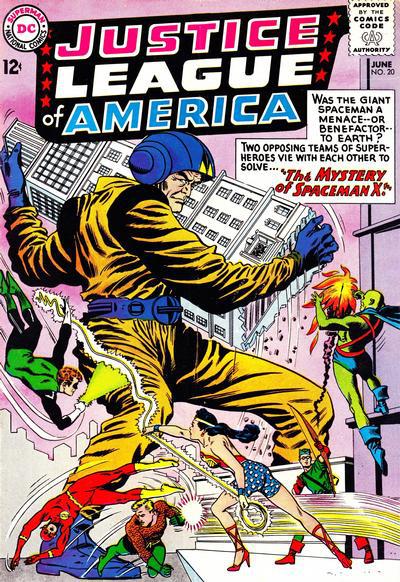

In [243]:
# TODO: update get_random_sample_of_covers to drop duplicate images
# TODO: update get_random_sample_of_covers to include cover metadata

random_cover = get_random_sample_of_covers(df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()], 
                                                    character="Wonder Woman", 
                                                    n=1)

synopsis = random_cover[list(random_cover.keys())[0]]["synopsis"]
cover_pencils = random_cover[list(random_cover.keys())[0]]["cover_pencils"]
cover_inks = random_cover[list(random_cover.keys())[0]]["cover_inks"]
cover_colors = random_cover[list(random_cover.keys())[0]]["cover_colors"]
characters = random_cover[list(random_cover.keys())[0]]["characters"]


print("Pencils: {}, Colors: {}, Colors: {}".format(cover_pencils, cover_inks, cover_colors), '\n')

print("Characters: {}".format(characters), '\n')
print("Synopsis: {}".format(synopsis), '\n')

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
im = Image.open("." + image_path)
im

In [372]:
def character_concurrence(df: DataFrame, character: str, character_counts: dict, top_n: int):
    df = df["cover_characters_list_aliases"].dropna()
    df = df[df.apply(lambda x: character in x)]
    characters = pd.Series(analyzer.flatten(df.values)).value_counts().index[:top_n]
    characters = filter(lambda x: (x!= "''") & (x != "'"), characters)
    return {k: character_counts[k] for k in characters}


justice_league = ["Superman", "Batman",  "Green Lantern", "Wonder Woman", "Flash", "Aquaman", "Cyborg"]

characters_dict = {}

for member in justice_league:
    d = character_concurrence(df=df_non_dupes, character=member, character_counts=character_counts,  top_n=20)
    characters_dict.update(d)

print("{} characters have been identified".format(len(characters_dict.keys())))
characters_dict

50 characters have been identified


{'Superman': 4071,
 'Batman': 5278,
 'Wonder Woman': 1794,
 'Green Lantern': 2640,
 'Lois Lane': 525,
 'Flash': 1552,
 'Aquaman': 709,
 'Robin': 1989,
 'Jimmy Olsen': 293,
 'Martian Manhunter': 457,
 'Supergirl': 662,
 'Lex Luthor': 284,
 'Cyborg': 437,
 'Green Arrow': 794,
 'Hawkman': 615,
 'The Flash': 449,
 'Superboy': 1012,
 'Black Canary': 558,
 'Perry White': 78,
 'Brainiac': 81,
 'Catwoman': 617,
 'Joker': 417,
 'Batgirl': 460,
 'Two-Face': 174,
 'Nightwing': 595,
 'Penguin': 145,
 'Scarecrow': 146,
 'The Atom': 167,
 'Atom': 248,
 'Stargirl': 117,
 'Power Girl': 250,
 'Dr. Fate': 174,
 'Hawkgirl': 191,
 'Katana': 225,
 'Dr. Mid-Nite': 119,
 'Steve Trevor': 106,
 'Elongated Man': 158,
 'Wildcat': 141,
 'Kid Flash': 309,
 'Captain Cold': 83,
 'Mera': 74,
 'Aqualad': 153,
 'Zatanna': 129,
 'Starfire': 354,
 'Wonder Girl': 431,
 'Raven': 261,
 'Changeling': 146,
 'Beast Boy': 213,
 'Jericho': 84,
 'Terra': 84}

### Create Training Dirs

#### Cover Images

In [374]:
# TODO: exclude splash page covers
# TODO: remove any image files that contain a "\t", since this is the column delimiter used by our DataBunch loader

analyzer.create_training_dirs(df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()], 
                              characters_dict=characters_dict, 
                              save_dir="justice_league")

We started with 30136 covers. After de-duping for character overlap we have 16460.


In [314]:
# write synopses to dir

ordered_synopsis = df_non_dupes[df_non_dupes["synopsis"].\
                     notnull()][["series_name", "on_sale_year",  "issue_number", "synopsis",  "cover_genre"]].\
                     sort_values(["series_name", "on_sale_year",  "issue_number"], ascending=True).\
                     reset_index(drop=True)


ordered_synopsis["on_sale_year"] = ordered_synopsis["on_sale_year"].fillna(9999.0).astype(int).astype(str)

# ordered_synopsis.drop(["issue_number"], axis=1).describe().T

# ordered_synopsis

In [313]:
ordered_synopsis["cover_genre"].value_counts()[:20]

superhero                                  25843
science fiction                             1340
horror-suspense                              969
romance                                      617
anthropomorphic-funny animals                510
science fiction; superhero                   481
humor                                        430
western-frontier                             423
sword and sorcery                            408
war                                          383
adventure                                    375
fantasy-supernatural                         329
crime                                        233
superhero; science fiction                   233
humor; teen                                  200
fantasy-supernatural; superhero              156
fantasy-supernatural; sword and sorcery      142
horror-suspense; superhero                   136
jungle                                       123
humor; superhero                             114
Name: cover_genre, d

In [312]:
for genre in ordered_synopsis["cover_genre"].dropna().unique():
    df_genre = ordered_synopsis[ordered_synopsis["cover_genre"] == genre][["series_name", "synopsis"]]
    df_genre.columns = ["label", "text"]
    df_genre.dropna().to_csv("./text/{}_synopsis.csv".format(genre.replace("; ", "_")), index=False)

In [281]:
synopses = ordered_synopsis[["series_name", "synopsis"]]
synopses.columns = ["label", "text"]
synopses.dropna().to_csv("./text/all_synopsis.csv", index=False)

In [306]:
# synopses[synopses["label"] == "Action Comics"].iloc[0]["text"]

In [291]:
# # # TODO: load metadata and return aggregate / summary statistics
# import jsonlines

# logged_metadata = []

# with jsonlines.open('../metadata/log.jsonl', mode='r') as reader:
#     for item in reader:
#         logged_metadata.append(item)
        
# log = pd.DataFrame(logged_metadata)

# log[["issue_count", "publisher_id", "publisher_page"]] = log[["issue_count", "publisher_id", "publisher_page"]].astype(int)

# sorted_log = log.\
# drop_duplicates().\
# sort_values(by=["publisher_id",  "publisher_page", "series"])\
# [["publisher_id",  "publisher_page", "series", "issue_count"]]

In [292]:
# sorted_log[sorted_log["publisher_id"] == 78][40:]